## Recurrent Neural Network (RNN)
- RNN is essentially repeating ANN but information get pass through from previous non-linear activation function output.
- Steps of RNN:
  1. Import Libraries
  2. Prepare Dataset
  3. Create RNN Model
    - hidden layer dimension is 100
    - number of hidden layer is 1
  4. Instantiate Model
  5. Instantiate Loss
    - Cross entropy loss
    - It also has softmax(logistic function) in it.
  6. Instantiate Optimizer
    - SGD Optimizer
  7. Traning the Model
  8. Prediction


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
print(os.listdir("/content/drive/MyDrive/kaggle/MNIST"))

['train.csv', 'test.csv', 'sample_submission.csv', 'LeNet.ipynb', 'LeNet_1', 'LeNet_1의 사본', 'submission.csv', 'RNN.ipynb']


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [4]:
train = pd.read_csv(r"/content/drive/MyDrive/kaggle/MNIST/train.csv", dtype = np.float32)

In [5]:
# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

In [6]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [7]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. 
# Therefore first we create tensor, then we will create variable

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [8]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [9]:
# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

In [10]:
# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

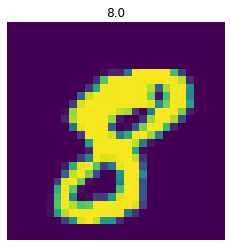

In [11]:
# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [12]:
class RNNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(RNNModel, self).__init__()

    # Number of hidden dimension
    self.hidden_dim = hidden_dim

    # Number of hidden layers
    self.layer_dim = layer_dim

    # RNN
    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

    # Readout layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  
  def forward(self, x):

    # Initialize hidden state with zeros
    h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    # One time step
    out, hn = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out

In [13]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [14]:
# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

In [15]:
# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [16]:
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

In [17]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
print(model)

RNNModel(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [18]:
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

In [19]:
# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0

            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.5385016202926636  Accuracy: 33.19047546386719 %
Iteration: 1000  Loss: 1.0151067972183228  Accuracy: 67.42857360839844 %
Iteration: 1500  Loss: 0.5969290733337402  Accuracy: 83.0 %
Iteration: 2000  Loss: 0.490479975938797  Accuracy: 83.9047622680664 %
Iteration: 2500  Loss: 0.2202877551317215  Accuracy: 89.51190185546875 %
Iteration: 3000  Loss: 0.24068884551525116  Accuracy: 92.03571319580078 %
Iteration: 3500  Loss: 0.310756117105484  Accuracy: 93.20237731933594 %
Iteration: 4000  Loss: 0.10378612577915192  Accuracy: 93.03571319580078 %
Iteration: 4500  Loss: 0.3170258700847626  Accuracy: 94.88095092773438 %
Iteration: 5000  Loss: 0.08715919405221939  Accuracy: 95.8452377319336 %
Iteration: 5500  Loss: 0.1667279303073883  Accuracy: 95.95237731933594 %
Iteration: 6000  Loss: 0.13533055782318115  Accuracy: 95.22618865966797 %
Iteration: 6500  Loss: 0.04068939387798309  Accuracy: 96.23809814453125 %
Iteration: 7000  Loss: 0.1962258368730545  Accuracy: 96.96428680

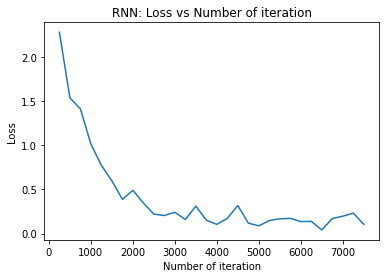

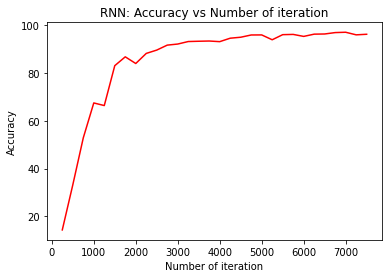

In [21]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()